***
# <font color=red>Building an Image Classifier using AutoMLx</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle AutoMLx Team </font></p>

***

Image Classification Demo Notebook.

Copyright © 2025, Oracle and/or its affiliates.

Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl/

## Overview of this Notebook

In this notebook we will build a image classifier using the Oracle AutoMLx tool for the public PneumoniaMNIST dataset which is part of MedMNIST datasets. The dataset is a multi-label classification dataset, and more details about the dataset can be found at https://medmnist.com/.
We explore the various options provided by the Oracle AutoMLx tool, allowing the user to exercise control over the AutoML training process. We then evaluate the different models trained by AutoML.

---
## Prerequisites

  - Experience level: Novice (Python and Machine Learning)
  - Professional experience: Some industry experience
---

## Business Use

Data analytics and modeling problems using Machine Learning (ML) are becoming popular and often rely on data science expertise to build accurate ML models. Such modeling tasks primarily involve the following steps:
- Pick an appropriate model for the given dataset and prediction task at hand.
- Tune the chosen model’s hyperparameters for the given dataset.

All of these steps are significantly time consuming and heavily rely on data scientist expertise. Unfortunately, to make this problem harder, the best model, and hyperparameter choice widely varies with the dataset and the prediction task. Hence, there is no one-size-fits-all solution to achieve reasonably good model performance. Using a simple Python API, AutoMLx can quickly jump-start the datascience process with an accurately-tuned model for a given prediction task.

## Table of Contents

- <a href='#setup'>Setup</a>
- <a href='#load-data'>Load the PneumoniaMNIST dataset</a>
- <a href='#AutoML'>AutoML</a>
  - <a href='#Engine'>Setting the execution engine</a>
  - <a href='#provider'>Create an Instance of Oracle AutoMLx</a>
  - <a href='#default'>Train a Model using AutoML</a>
  - <a href='#analyze'>Analyze the AutoML optimization process </a>
      - <a href='#algorithm-selection'>Algorithm Selection</a>
      - <a href='#adaptive-sampling'>Adaptive Sampling</a>
      - <a href='#model-tuning'>Model Tuning</a>
      - <a href='#confusion-matrix'>Confusion Matrix</a>
  - <a href='#advanced'> Advanced AutoML Configuration </a>
- <a href='#ref'>References</a>

<a id='setup'></a>
## Setup

Basic setup for the Notebook.

In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2

Load the required modules.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Settings for plots
plt.rcParams['figure.figsize'] = [4, 3]
plt.rcParams['font.size'] = 15

import automlx

<a id='load-data'></a>
## Load the PneumoniaMNIST dataset
We start by reading in the dataset from Hugging Face.

In [3]:
dataset = load_dataset("albertvillanova/medmnist-v2", "pneumoniamnist")

Lets look at a few of the values in the data

In [4]:
dataset["train"][:5]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>],
 'label': [1, 1, 1, 1, 1]}

Plot one of the images as an example

In [5]:
print("Pneumonia" if dataset["train"][0]['label'] == 1 else 'Normal')
dataset["train"][0]['image']

Pneumonia


We visualize the distribution of the target variable in the training data.

In [6]:
y_df = pd.DataFrame(dataset["train"]["label"])
y_df.columns = ['label']

fig = px.histogram(y_df["label"].apply(lambda x: "Normal" if x == 0 else "Pneumonia"), x="label", barmode="group")
fig.show()

We now separate the predictions (`y`) from the training data (`X`) for both the training (70%) and test (30%) datasets. The training set will be used to create a Machine Learning model using AutoML, and the test set will be used to evaluate the model's performance on unseen data.

In [7]:
X = pd.DataFrame(dataset["train"]["image"], columns=['images'])
y = pd.DataFrame(dataset["train"]["label"])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

# reducing the number of samples in training set to speed up the demo
X_train = X_train[:1000]
y_train = y_train[:1000]

<a id='AutoML'></a>
## AutoML

<a id='provider'></a>
### Create an instance of Oracle AutoMLx

The Oracle AutoMLx solution provides a pipeline that automatically finds a tuned model given a prediction task and a training dataset.

AutoML consists of three main steps for image classification:
- **Algorithm Selection** : Identify the right classification algorithm for a given dataset.
- **Adaptive Sampling** : Select a subset of the data samples for the model to be trained on.
- **Model Tuning** : Find the right model parameters (including model size) that maximize score for the given dataset.

All these pieces are readily combined into a simple AutoML pipeline which automates the entire Machine Learning process with minimal user input/interaction.

<a id='default'></a>
### Train a model using AutoML

The AutoMLx API is quite simple to work with. We create an instance of the pipeline. Next, the training data is passed to the `fit()` function which executes the previously mentioned steps.
Note that we decreased number of tuning trials in Model Tuning, to speed up the demo notebook.

In [8]:
est1 = automlx.Pipeline(task='classification', max_tuning_trials=10, score_metric="balanced_accuracy")
est1.fit(X_train, y_train)

[2025-04-25 03:15:24,710] [automlx.backend] Overwriting ray session directory to /tmp/j9903zbf/ray, which will be deleted at engine shutdown. If you wish to retain ray logs, provide _temp_dir in ray_setup dict of engine_opts when initializing the AutoMLx engine.


[2025-04-25 03:15:29,829] [automlx.interface] Dataset shape: (1000,1)


[2025-04-25 03:15:33,331] [sanerec.autotuning.parameter] Hyperparameter epsilon autotune range is set to its validation range. This could lead to long training times


[2025-04-25 03:15:33,859] [sanerec.autotuning.parameter] Hyperparameter repeat_quality_threshold autotune range is set to its validation range. This could lead to long training times


[2025-04-25 03:15:33,868] [sanerec.autotuning.parameter] Hyperparameter scope autotune range is set to its validation range. This could lead to long training times


[2025-04-25 03:15:33,941] [automlx.data_transform] Running preprocessing. Number of features: 2


[2025-04-25 03:15:34,824] [automlx.data_transform] Preprocessing completed. Took 0.883 secs


[2025-04-25 03:15:34,870] [automlx.process] Running Model Generation


[2025-04-25 03:15:34,911] [automlx.process] Model Generation completed.


[2025-04-25 03:15:34,981] [automlx.model_selection] Running Model Selection


[2025-04-25 03:18:12,401] [automlx.model_selection] Model Selection completed - Took 157.420 sec - Selected models: [['ResNet']]


[2025-04-25 03:18:12,429] [automlx.adaptive_sampling] Running Adaptive Sampling. Dataset shape: (1000,2).


[2025-04-25 03:18:12,479] [automlx.adaptive_sampling] Adaptive Sampling: top_limit: 583 < bottom_limit: 1000,
sampling process will be skipped


[2025-04-25 03:18:12,489] [automlx.adaptive_sampling] Adaptive Sampling: top_limit: 146 < bottom_limit: 1000,
sampling process will be skipped


[2025-04-25 03:18:12,584] [automlx.feature_selection] Starting feature ranking for ResNet


[2025-04-25 03:18:12,585] [automlx.feature_selection] min_features is larger than model input features for ResNet, skipping feature selection for it


[2025-04-25 03:18:12,620] [automlx.trials] Running Model Tuning for ['ResNet']


[2025-04-25 03:31:47,337] [automlx.trials] Best parameters for ResNet: {'optimizer_class': 'Adam', 'shuffle_dataset_each_epoch': True, 'optimizer_params': {}, 'criterion_class': None, 'criterion_params': {}, 'scheduler_class': None, 'scheduler_params': {}, 'batch_size': 128, 'lr': 0.0031630600334930504, 'epochs': 18, 'input_transform': 'auto', 'tensorboard_dir': None, 'use_tqdm': None, 'prediction_batch_size': 128, 'prediction_input_transform': 'auto', 'shuffling_buffer_size': None, 'freeze.encoder': False, 'load.encoder': None, 'size': '18'}


[2025-04-25 03:31:47,338] [automlx.trials] Model Tuning completed. Took: 814.718 secs


[2025-04-25 03:31:48,319] [automlx.interface] Re-fitting pipeline


[2025-04-25 03:31:48,337] [automlx.final_fit] Skipping updating parameter seed, already fixed by FinalFit_d9a60282-f


[2025-04-25 03:33:54,686] [automlx.interface] AutoMLx completed.


A model is then generated (`est1`) and can be used for prediction tasks. We use the `balanced accuracy` scoring metric to evaluate the performance of this model on unseen data (`X_test`).

In [9]:
y_pred = est1.predict(X_test)
score_default = balanced_accuracy_score(y_test, y_pred)

print(f'Score on test data : {score_default:.4f}')

Score on test data : 0.8916


<a id='analyze'></a>
### Analyze the AutoML optimization process

During the AutoML process, a summary of the optimization process is logged. It consists of:
- Information about the training data .
- Information about the AutoML, such as:
    - Selected algorithm that was the best choice for this data;
    - Selected hyperparameters for the selected algorithm.

AutoMLx provides a `print_summary` API to output all the different trials performed.

In [10]:
est1.print_summary()

We also provide the capability to visualize the results of each stage of the AutoML.

<a id='algorithm-selection'></a>
#### Algorithm Selection

The plot below shows the scores predicted by Algorithm Selection for each algorithm. The horizontal line shows the average score across all algorithms. Algorithms below the line are colored turquoise, whereas those with a score higher than the mean are colored teal.

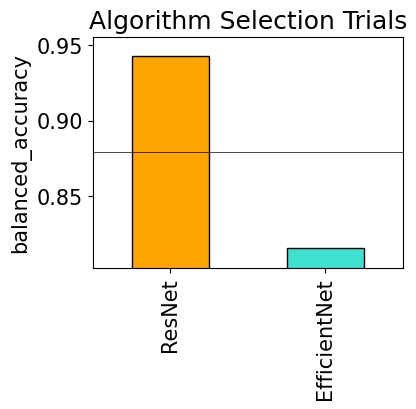

In [11]:
# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[est1.completed_trials_summary_["Step"].str.contains('Model Selection')]
name_of_score_column = f"Score ({est1._inferred_score_metric[0].name})"
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column],inplace=True)
colors = []
scores = trials[name_of_score_column].tolist()
models = trials['Algorithm'].tolist()
y_margin = 0.10 * (max(scores) - min(scores))
s = pd.Series(scores, index=models).sort_values(ascending=False)
s = s.dropna()
for f in s.keys():
    if f.strip()  ==  est1.selected_model_.strip():
        colors.append('orange')
    elif s[f] >= s.mean():
        colors.append('teal')
    else:
        colors.append('turquoise')

fig, ax = plt.subplots(1)
ax.set_title("Algorithm Selection Trials")
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.set_ylabel(est1._inferred_score_metric[0].name)
s.plot.bar(ax=ax, color=colors, edgecolor='black')
ax.axhline(y=s.mean(), color='black', linewidth=0.5)
plt.show()

<a id='model-tuning'></a>
#### Model Tuning

Model Tuning is the last stage of AutoML, and focuses on improving the chosen algorithm's score on the reduced dataset (after Adaptive Sampling). AutoML uses a novel algorithm to search across many hyperparameters dimensions, and converge automatically when optimal hyperparameters are identified. Each trial represents a particular hyperparameters configuration for the selected model.

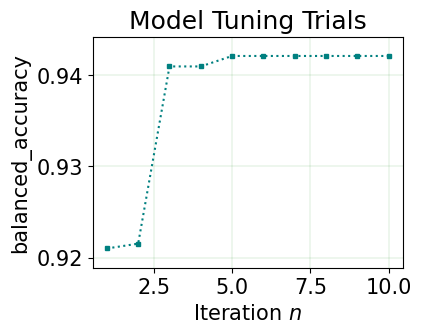

In [12]:
# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[est1.completed_trials_summary_["Step"].str.contains('Model Tuning')]
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace=True)
trials = trials.sort_values(by=['Finished'],ascending=True)
scores = trials[name_of_score_column].tolist()
score = []
score.append(scores[0])
for i in range(1,len(scores)):
    if scores[i]>= score[i-1]:
        score.append(scores[i])
    else:
        score.append(score[i-1])
y_margin = 0.10 * (max(score) - min(score))

fig, ax = plt.subplots(1)
ax.set_title("Model Tuning Trials")
ax.set_xlabel("Iteration $n$")
ax.set_ylabel(est1._inferred_score_metric[0].name)
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(score) - y_margin, max(score) + y_margin)
ax.plot(range(1, len(trials) + 1), score, 'k:', marker="s", color='teal', markersize=3)
plt.show()

<a id='advanced'></a>
### Advanced AutoML Configuration

For customizing the model tuning step, the range of the hyperparameters of each of the models can be specified and passed to the pipeline.

In [13]:
shared_hyperparameters = {
    "epochs": {'range': [1,5],
               'type': 'discrete'
              },
    "batch_size": {'range': [16, 32],
                   'type': 'discrete'
                  }
}
search_space = {
         "EfficientNet" : {
        "size": {'range': ["b2","b6"],
                 'type': 'categorical'
                },
        **shared_hyperparameters
    }
}

You can also configure the pipeline with suitable parameters according to your needs.

In [14]:
custom_pipeline = automlx.Pipeline(
    task='classification',
    model_list=[                 # Specify the models you want the AutoML to consider
        'EfficientNet',
    ],
    n_algos_tuned=2,             # Choose how many models to tune
    adaptive_sampling=False,     # Disable or enable Adaptive Sampling step. Default to `True`
    search_space=search_space,   # You can specify the hyper-parameters and ranges AutoML searches
    max_tuning_trials=2,         # The maximum number of tuning trials. Can be integer or Dict (max number for each model)
    score_metric='f1_macro',     # Any scikit-learn metric or a custom function
)

A few of the advanced settings can be passed directly to the pipeline's fit method, instead of its constructor.

In [15]:
custom_pipeline.fit(
    X_train,
    y_train,
    time_budget= 20,    # Specify time budget in seconds
    cv='auto'           # Automatically pick a good cross-validation (cv) strategy for the user's dataset.
                        # Ignored if X_valid and y_valid are provided.
                        # Can also be:
                        #   - An integer (for example, to use 5-fold cross validation)
                        #   - A list of data indices to use as splits (for advanced, such as time-based splitting)
)
y_pred = custom_pipeline.predict(X_test)
score_default = balanced_accuracy_score(y_test, y_pred)

print(f'Score on test data : {score_default:.4f}')

[2025-04-25 03:34:00,140] [automlx.interface] Dataset shape: (1000,1)


[2025-04-25 03:34:00,188] [automlx.interface] Adaptive Sampling disabled.


[2025-04-25 03:34:00,225] [automlx.data_transform] Running preprocessing. Number of features: 2


[2025-04-25 03:34:01,091] [automlx.data_transform] Preprocessing completed. Took 0.866 secs


[2025-04-25 03:34:01,123] [automlx.process] Running Model Generation


[2025-04-25 03:34:01,170] [automlx.process] Model Generation completed.


[2025-04-25 03:34:01,196] [automlx.model_selection] Running Model Selection


[2025-04-25 03:34:01,197] [automlx.trials] Fewer models (1) than top_k (2) provided, skipping...


[2025-04-25 03:34:01,305] [automlx.feature_selection] Starting feature ranking for EfficientNet


[2025-04-25 03:34:01,305] [automlx.feature_selection] min_features is larger than model input features for EfficientNet, skipping feature selection for it


[2025-04-25 03:34:01,340] [automlx.trials] Running Model Tuning for ['EfficientNet']


[2025-04-25 03:34:16,157] [automlx.backend] Job cda0b026-21c0-11f0-b4ee-00001701c949 <> EfficientNet - Trial: 2 - Split: 3 of 5
                            failed
Stack trace:
Traceback (most recent call last):
  File "/scratch_user/jenkins/workspace/v2_long_regress/src/automlx/_backend/utils.py", line 65, in _handle_job_exception
    complete_results = profile.function(
  File "/scratch_user/jenkins/workspace/v2_long_regress/src/automlx/_utils/profile.py", line 133, in profile_wrapper
    ) = _profile_resources(
  File "/scratch_user/jenkins/workspace/v2_long_regress/src/automlx/_utils/profile.py", line 655, in _profile_resources
    function_output = func(*args, **kwargs, **pf)
  File "/scratch_user/jenkins/workspace/v2_long_regress/src/automlx/_trials/strategies/base.py", line 112, in run
    return self._run(reporter, resources, pipeline, train_dataset, callback_manager, pf=pf)
  File "/scratch_user/jenkins/workspace/v2_long_regress/src/automlx/_trials/strategies/standard.py", line

[2025-04-25 03:34:16,206] [automlx.backend] Job cda0b026-21c0-11f0-b4ee-00001701c949 <> EfficientNet - Trial: 2 - Split: 2 of 5
                            failed
Stack trace:
Traceback (most recent call last):
  File "/scratch_user/jenkins/workspace/v2_long_regress/src/automlx/_backend/utils.py", line 65, in _handle_job_exception
    complete_results = profile.function(
  File "/scratch_user/jenkins/workspace/v2_long_regress/src/automlx/_utils/profile.py", line 133, in profile_wrapper
    ) = _profile_resources(
  File "/scratch_user/jenkins/workspace/v2_long_regress/src/automlx/_utils/profile.py", line 655, in _profile_resources
    function_output = func(*args, **kwargs, **pf)
  File "/scratch_user/jenkins/workspace/v2_long_regress/src/automlx/_trials/strategies/base.py", line 112, in run
    return self._run(reporter, resources, pipeline, train_dataset, callback_manager, pf=pf)
  File "/scratch_user/jenkins/workspace/v2_long_regress/src/automlx/_trials/strategies/standard.py", line

[2025-04-25 03:34:17,092] [automlx.trials] Best parameters for EfficientNet: {'optimizer_class': 'Adam', 'shuffle_dataset_each_epoch': True, 'optimizer_params': {}, 'criterion_class': None, 'criterion_params': {}, 'scheduler_class': None, 'scheduler_params': {}, 'batch_size': 16, 'lr': 0.001, 'epochs': 1, 'input_transform': 'auto', 'tensorboard_dir': None, 'use_tqdm': None, 'prediction_batch_size': 128, 'prediction_input_transform': 'auto', 'shuffling_buffer_size': None, 'freeze.encoder': False, 'load.encoder': None, 'size': 'b2'}


[2025-04-25 03:34:17,094] [automlx.trials] Model Tuning completed. Took: 15.754 secs


[2025-04-25 03:34:17,268] [automlx.interface] Re-fitting pipeline


[2025-04-25 03:34:17,284] [automlx.final_fit] Skipping updating parameter seed, already fixed by FinalFit_8072097a-a


2025-04-25 03:34:21,520	ERROR worker.py:409 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.


[2025-04-25 03:34:37,909] [automlx.interface] AutoMLx completed.


Score on test data : 0.5000


<a id='ref'></a>
## References
* Oracle AutoML http://www.vldb.org/pvldb/vol13/p3166-yakovlev.pdf
* scikit-learn https://scikit-learn.org/stable/
* Hugging Face https://huggingface.co/
* MedMNIST Dataset https://medmnist.com/